# Imports

In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
import glob
from model import CNN_Classifier_Lightning
import pytorch_lightning as pl
import torch
from torch.utils.data import TensorDataset, DataLoader


# Scratchwork

This is a scratchwork file for testing out data extraction on .emsa sprectra data files.

In [2]:
def read_emsa_spectrum(filepath: str, header_lines: int = 31) -> np.ndarray:
    """
    Reads a .emsa file and extracts the numerical data spectrum.

    Args:
        filepath (str): The full path to the .emsa file.
        header_lines (int): The number of header lines to skip.

    Returns:
        np.ndarray: A 1D NumPy array containing the spectrum data.
    """
    try:
        spectrum = np.loadtxt(filepath, skiprows=header_lines)
        return spectrum
    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
        return np.array([]) # Return an empty array on error
    except ValueError:
        print(f"Error: Could not convert data to numbers after the header.")
        print("Please check the file to ensure all lines after the header are numeric.")
        return np.array([])
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return np.array([])
    
def spectrums_from_directory(directory):
    emsa_files = sorted(glob.glob(os.path.join(directory, '*.emsa')))
    if emsa_files:
        list_of_spectra = [read_emsa_spectrum(f) for f in emsa_files]
        spectra_array = np.array([s for s in list_of_spectra if s.size > 0])
        
        if spectra_array.size == 0:
            print("Could not read any valid spectra from the files found.")
        
        return spectra_array
    else:
        print(f"No .emsa files found in the directory: {directory}")


In [ ]:
sp = read_emsa_spectrum(r"D:\ANL Data Storage\Phenom Data\PbSn_60\Compiled Spectra\Pb\spectrum.emsa")
print(sp.shape)
print(sp)
plt.plot(sp)

In [ ]:
sps = spectrums_from_directory(r"D:\ANL Data Storage\Phenom Data\PbSn_60\Compiled Spectra\Pb")
sps.shape

In [ ]:
random_indices = np.random.randint(0, 19, size=(4, 256, 256))
spectral_volume = sps[random_indices]
spectral_volume.shape

In [2]:
from data import generate_training_data

training_HSI, training_classes = generate_training_data(
    image_directory = r"/Users/jacques/Documents/UChicago/UChicago Research/Phatak Research/NolanImages/Compiled Images/Compiled Images/Two-tone/Training",
    target_size = (256, 256),
    spectrum_directories = [
        r"/Users/jacques/Documents/UChicago/UChicago Research/Phatak Research/NolanImages/Compiled Images/Compiled Spectra/Sn",
        r"/Users/jacques/Documents/UChicago/UChicago Research/Phatak Research/NolanImages/Compiled Images/Compiled Spectra/Pb"
    ],
    spectrum_range = (0, 9)
)

val_HSI, val_classes = generate_training_data(
    image_directory = r"/Users/jacques/Documents/UChicago/UChicago Research/Phatak Research/NolanImages/Compiled Images/Compiled Images/Two-tone/Validation",
    target_size = (256, 256),
    spectrum_directories = [
        r"/Users/jacques/Documents/UChicago/UChicago Research/Phatak Research/NolanImages/Compiled Images/Compiled Spectra/Sn",
        r"/Users/jacques/Documents/UChicago/UChicago Research/Phatak Research/NolanImages/Compiled Images/Compiled Spectra/Pb"
    ],
    spectrum_range = (10, 19)
)

Scanning directory: /Users/jacques/Documents/UChicago/UChicago Research/Phatak Research/NolanImages/Compiled Images/Compiled Images/Two-tone/Training
Looking for files with extensions: ('.jpg', '.jpeg', '.png')
All images will be resized to: (256, 256)

Successfully compiled 2 images.
Masking over data for class 0...
Masking over data for class 1...
Scanning directory: /Users/jacques/Documents/UChicago/UChicago Research/Phatak Research/NolanImages/Compiled Images/Compiled Images/Two-tone/Validation
Looking for files with extensions: ('.jpg', '.jpeg', '.png')
All images will be resized to: (256, 256)

Successfully compiled 2 images.
Masking over data for class 0...
Masking over data for class 1...


In [3]:
np.save(r"data\training_HSI", training_HSI)
np.save(r"data\training_classes", training_classes)
np.save(r"data\validation_HSI", val_HSI)
np.save(r"data\validation_classes", val_classes)

# Train CNN

In [3]:
training_HSI = np.load(r"C:\Users\labuser\Downloads\PyPhenom (2.1)\PyPhenom\Jacques_Argonne_Internship\Phenom Repositories\SLADS-Net_V3\SLADS-Net\measurement\Generated Training Data\training_HSI.npy")
training_classes = np.load(r"C:\Users\labuser\Downloads\PyPhenom (2.1)\PyPhenom\Jacques_Argonne_Internship\Phenom Repositories\SLADS-Net_V3\SLADS-Net\measurement\Generated Training Data\datatraining_classes.npy")
val_HSI = np.load(r"C:\Users\labuser\Downloads\PyPhenom (2.1)\PyPhenom\Jacques_Argonne_Internship\Phenom Repositories\SLADS-Net_V3\SLADS-Net\measurement\Generated Training Data\validation_HSI.npy")
val_classes = np.load(r"C:\Users\labuser\Downloads\PyPhenom (2.1)\PyPhenom\Jacques_Argonne_Internship\Phenom Repositories\SLADS-Net_V3\SLADS-Net\measurement\Generated Training Data\datavalidation_classes.npy")

In [4]:
HSI_training_tensor = torch.Tensor(training_HSI.reshape((-1, 1, training_HSI.shape[-1])))
classes_training_tensor = torch.Tensor(training_classes.reshape((-1, 1)))

HSI_val_tensor = torch.Tensor(val_HSI.reshape((-1, 1, val_HSI.shape[-1])))
classes_val_tensor = torch.Tensor(val_classes.reshape((-1, 1)))

In [17]:
model = CNN_Classifier_Lightning(input_shape=(val_HSI.shape[-1],), num_classes=2)

trainer = pl.Trainer(
    accelerator = "auto",
    #precision   = '16-mixed',
    devices     = 1,
    max_epochs  = 10,
    #gradient_clip_val=0.5,
    logger      = pl.loggers.TensorBoardLogger("lightning_logs/", name="CNN")
)

training_dataset = TensorDataset(HSI_training_tensor, classes_training_tensor)
val_dataset = TensorDataset(HSI_val_tensor, classes_val_tensor)

train_loader = DataLoader(training_dataset, batch_size=8192)
val_loader   = DataLoader(val_dataset, batch_size=8192)

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX 6000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
W0825 09:56:47.933000 286280 Lib\site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
c:\Users\labuser\Downloads\PyPhenom (2.1)\PyPhenom\Jacques_Argonne_Internship\Phenom Repositori

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\labuser\Downloads\PyPhenom (2.1)\PyPhenom\Jacques_Argonne_Internship\Phenom Repositories\SLADS-Net_V3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


c:\Users\labuser\Downloads\PyPhenom (2.1)\PyPhenom\Jacques_Argonne_Internship\Phenom Repositories\SLADS-Net_V3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
c:\Users\labuser\Downloads\PyPhenom (2.1)\PyPhenom\Jacques_Argonne_Internship\Phenom Repositories\SLADS-Net_V3\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 16/16 [00:04<00:00,  3.92it/s, v_num=1, train_loss=0.00467, val_loss=0.00583]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 16/16 [00:04<00:00,  3.91it/s, v_num=1, train_loss=0.00467, val_loss=0.00583]


In [18]:
classification = torch.softmax(
                    model(torch.tensor(val_HSI[1]).float().reshape(-1, 1, 2048))
                        .reshape(256,256,2), 2).detach().numpy()
print(classification.shape)

(256, 256, 2)


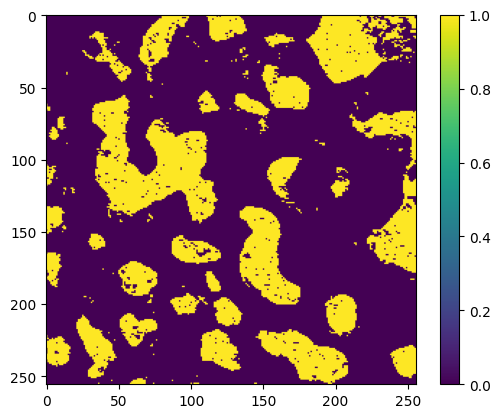

In [19]:
plt.imshow(np.argmax(classification[:,:], axis=2))
plt.colorbar()
plt.show()

In [21]:
torch.save(model.model.state_dict(), r"C:\Users\labuser\Downloads\PyPhenom (2.1)\PyPhenom\Jacques_Argonne_Internship\Phenom Repositories\SLADS-Net_V3\SLADS-Net\measurement\pretrained_models\CNN.pt")

## Classify a lead spectra and tin spectra using the CNN

In [5]:
# Load lead spectrum
lead_spectrum_emsa = r"C:\Users\labuser\Downloads\PyPhenom (2.1)\PyPhenom\Jacques_Argonne_Internship\Phenom Repositories\SLADS-Net_V3\SLADS-Net\measurement\Training Data\Compiled Images\Compiled Spectra\Pb\spectrum (2).emsa"
# lead_spectrum_np = np.load(r"C:\Users\labuser\Downloads\PyPhenom (2.1)\PyPhenom\Jacques_Argonne_Internship\Phenom Repositories\SLADS-Net_V3\SLADS-Net\Jacques Random\Spectra\Spectrum_run_2025-08-22_10-42-32.npy")
lead_spectrum_np = read_emsa_spectrum(lead_spectrum_emsa)

# Pass lead spectra into classifier to receive classification
lead_spectrum = torch.tensor(lead_spectrum_np).float().reshape(1, 1, 2048)


classification_lead = torch.softmax(model(lead_spectrum), dim=1).detach().numpy()
print(f'Lead classification is {np.argmax(classification_lead)}')

# Load tin spectra
tin_spectrum_emsa = r"C:\Users\labuser\Downloads\PyPhenom (2.1)\PyPhenom\Jacques_Argonne_Internship\Phenom Repositories\SLADS-Net_V3\SLADS-Net\measurement\Training Data\Compiled Images\Compiled Spectra\Sn\spectrum (2).emsa"
# tin_spectrum_np = np.load(r"C:\Users\labuser\Downloads\PyPhenom (2.1)\PyPhenom\Jacques_Argonne_Internship\Phenom Repositories\SLADS-Net_V3\SLADS-Net\Jacques Random\Spectra\Spectrum_run_2025-08-22_10-42-39.npy")
tin_spectrum_np = read_emsa_spectrum(tin_spectrum_emsa)

# Pass tin spectra into classifier to receive classification
tin_spectrum = torch.tensor(tin_spectrum_np).float().reshape(1, 1, 2048)


classification_tin = torch.softmax(model(tin_spectrum), dim=1).detach().numpy()
print(f'Tin classification is {np.argmax(classification_tin)}')

NameError: name 'model' is not defined

## Plot spectra

In [6]:
lead_spectrum = np.load(r"/Users/jacques/Documents/UChicago/UChicago Research/Phatak Research/ClonedRepoForCNNClassifierTesting/CNNTester/SLADS-Net/JacquesTrainingData/JacquesLeadTinTesting/Lead and Tin Spectra/SLADS Real-Time Runs/Spectra/Spectrum_run_2025-08-22_10-45-52.npy")
tin_spectrum = np.load(r"/Users/jacques/Documents/UChicago/UChicago Research/Phatak Research/ClonedRepoForCNNClassifierTesting/CNNTester/SLADS-Net/JacquesTrainingData/JacquesLeadTinTesting/Lead and Tin Spectra/SLADS Real-Time Runs/Spectra/Spectrum_run_2025-08-22_10-43-31.npy")
# lead_spectrum = np.load(r'/Users/jacques/Documents/UChicago/UChicago Research/Phatak Research/ClonedRepoForCNNClassifierTesting/CNNTester/SLADS-Net/JacquesTrainingData/JacquesLeadTinTesting/Lead and Tin Spectra/SLADS Real-Time Runs/Spectrum_run_2025-08-22_12-03-57.npy')
print(lead_spectrum[1].shape)
# Plot them
plt.plot(lead_spectrum, label="Lead")
plt.plot(tin_spectrum, label="Tin")
plt.axvline(x=243, color="blue", linestyle="--", linewidth=1)
plt.axvline(x=353, color="orange", linestyle="--", linewidth=1)
plt.legend()
plt.show()

# Classify them
lead_spectrum = torch.tensor(lead_spectrum).float().reshape(1, 1, 2048)
classification_lead = torch.softmax(model(lead_spectrum), dim=1).detach().numpy()
print(classification_lead)
print(f'Lead classification is {np.argmax(classification_lead)}')

# Tin spectrum
# tin_spectrum = torch.tensor(tin_spectrum).float().reshape(1, 1, 2048)
# classification_tin = torch.softmax(model(tin_spectrum), dim=1).detach().numpy()
# print(classification_tin)
# print(f'Tin classification is {np.argmax(classification_tin)}')

tin_spectrum = torch.tensor(tin_spectrum).float().reshape(1, 1, 2048)

# Forward pass
logits = model(tin_spectrum)

# Convert to probabilities
probs = torch.nn.functional.softmax(logits, dim=1)
print(f'Probabilities are {probs}')
# Detach before NumPy conversion
intermediate = probs.detach().numpy()

# Argmax in NumPy
classification_tin = np.argmax(intermediate)
print(f'Tin classification is {classification_tin}')

# Store classification result
# print(f'position is {position}')
# print(type(position))
# print(position.shape)
# print(position[0])
# print(position[1])




FileNotFoundError: [Errno 2] No such file or directory: '/Users/jacques/Documents/UChicago/UChicago Research/Phatak Research/ClonedRepoForCNNClassifierTesting/CNNTester/SLADS-Net/JacquesTrainingData/JacquesLeadTinTesting/Lead and Tin Spectra/SLADS Real-Time Runs/Spectra/Spectrum_run_2025-08-22_10-45-52.npy'

## Find lead spectra and tin spectra to compare

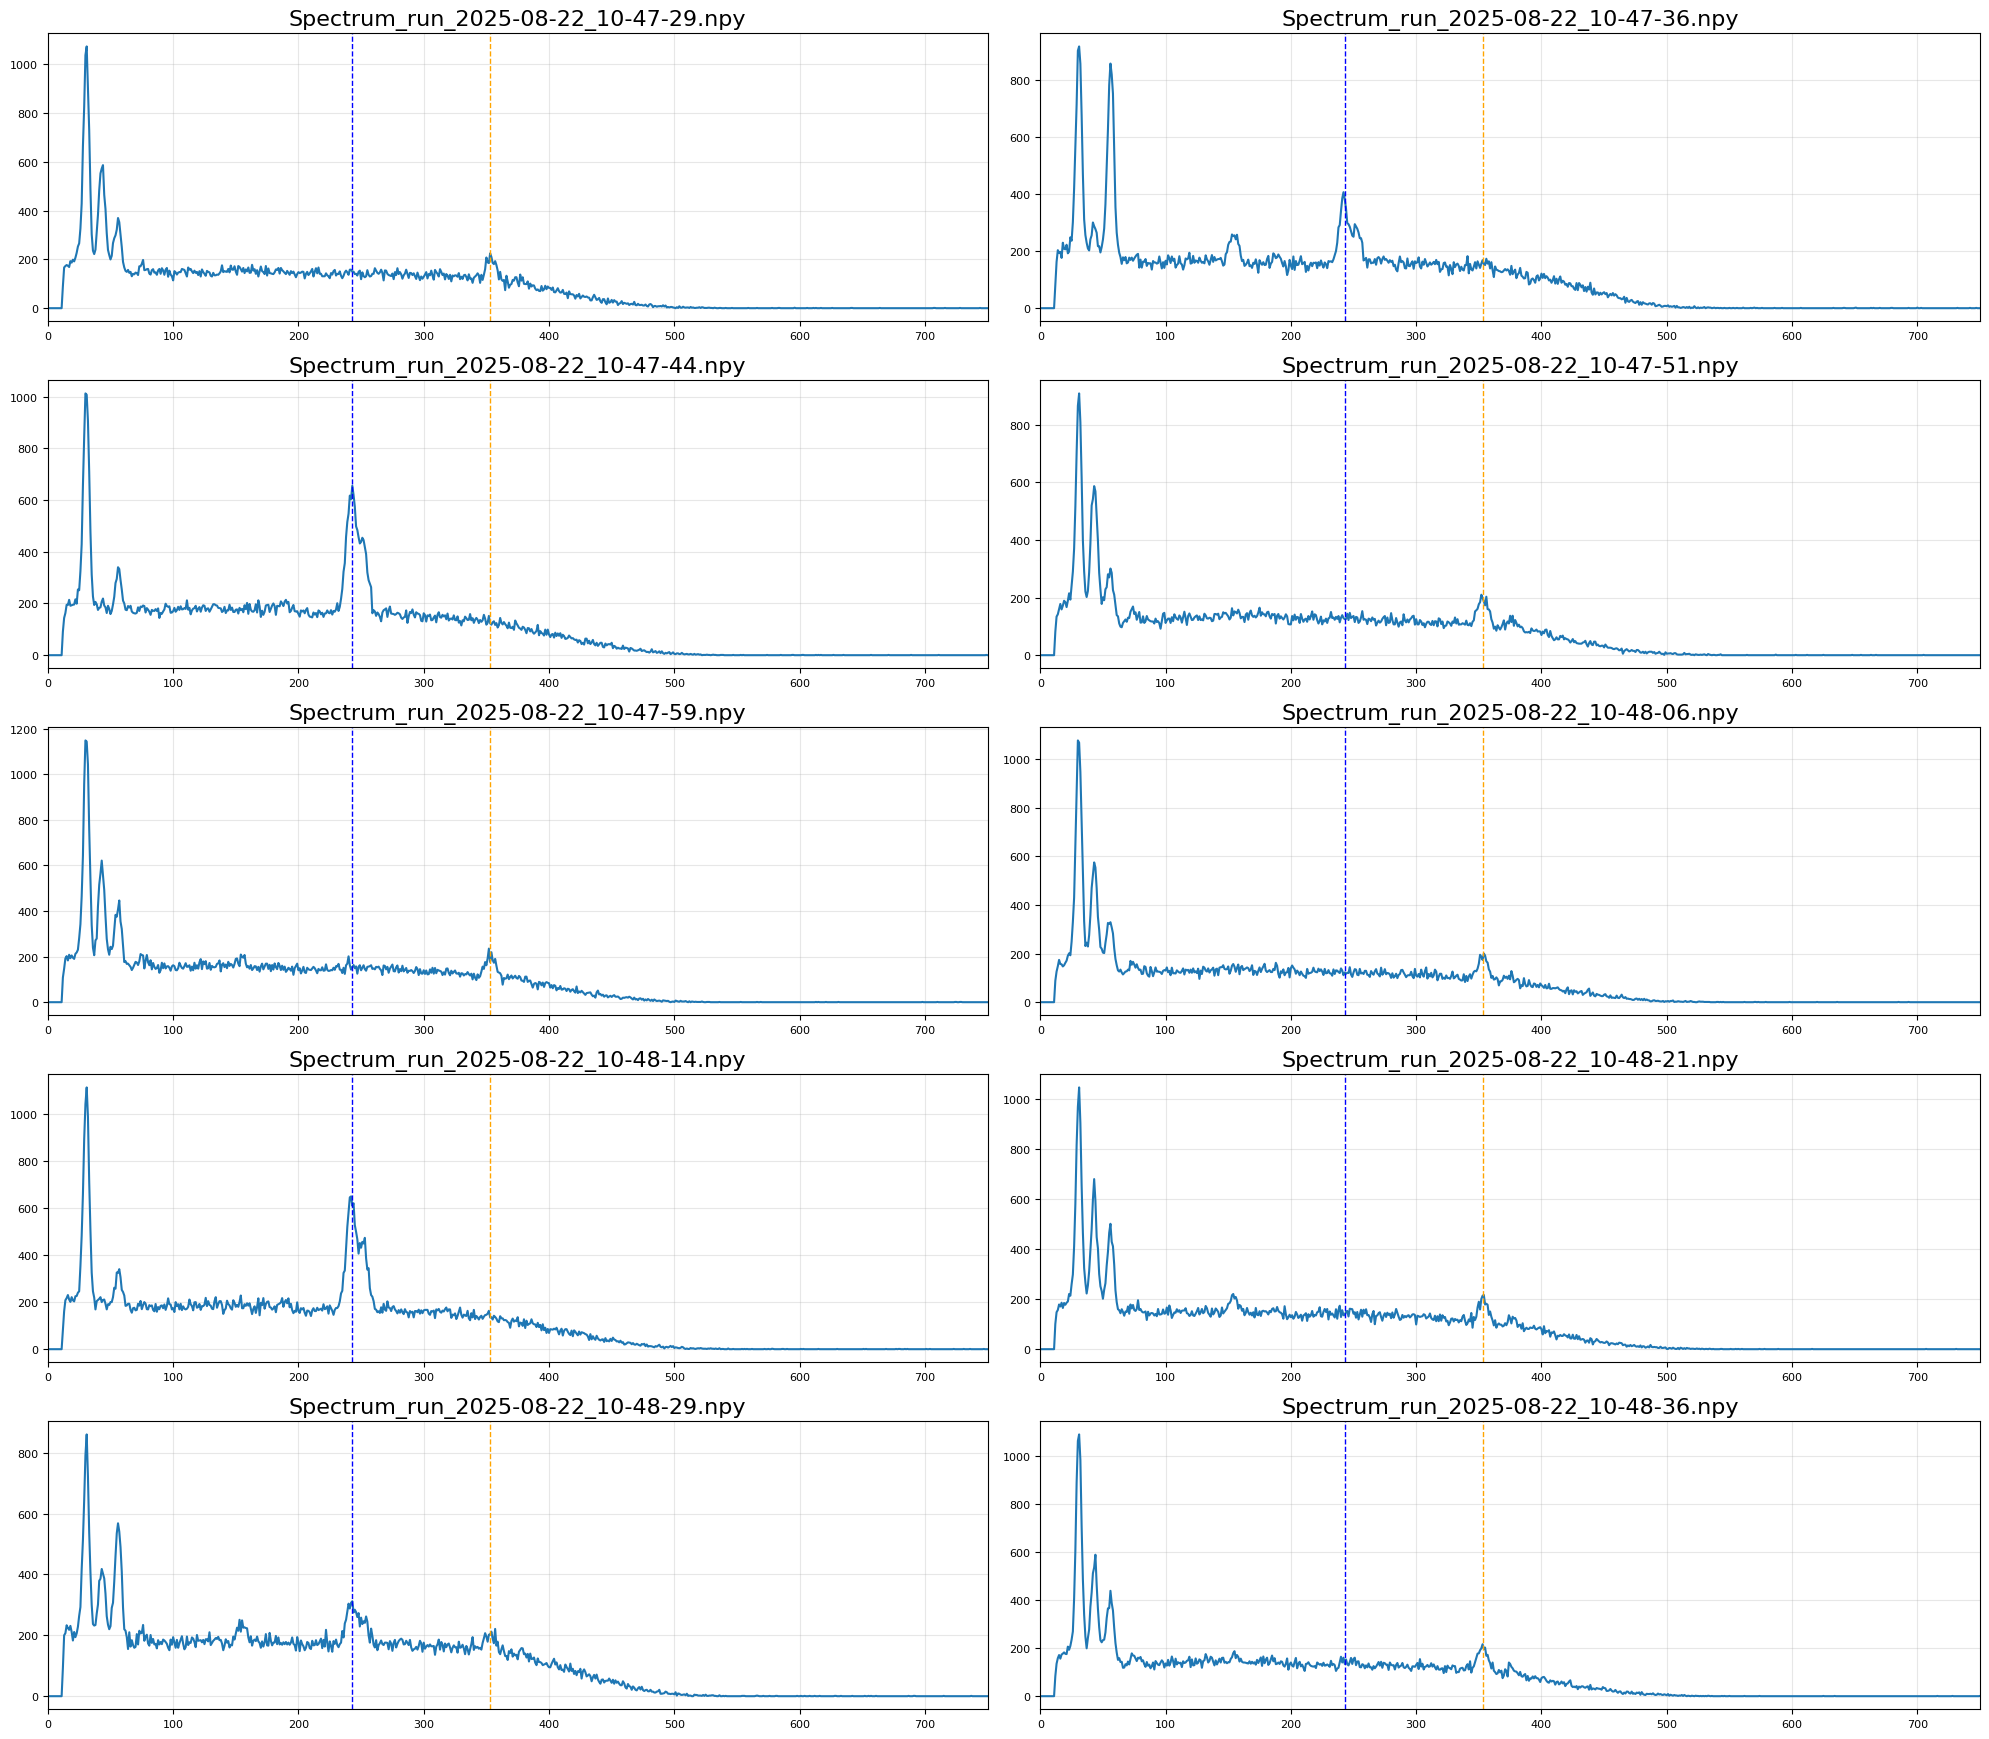

In [23]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt

# Path to your folder with .npy files
folder = r"C:\Users\labuser\Downloads\PyPhenom (2.1)\PyPhenom\Jacques_Argonne_Internship\Phenom Repositories\SLADS-Net_V3\SLADS-Net\Jacques Random\Spectra"

# Get .npy files (sorted) and keep first 20
files = sorted([f for f in os.listdir(folder) if f.endswith(".npy")])[40:50]
n = len(files)

# Layout: up to 5 columns, as many rows as needed
cols = 2
rows = math.ceil(n / cols) if n else 1
fig, axes = plt.subplots(rows, cols, figsize=(20, 3.5*rows))
axes = np.atleast_1d(axes).ravel()  # flatten even if rows=1

for i, filename in enumerate(files):
    data = np.load(os.path.join(folder, filename))
    y = np.ravel(data).astype(float)  # handle (2048,) or (2048,1)
    x = np.arange(y.size)

    ax = axes[i]
    ax.plot(x, y)
    ax.set_title(filename, fontsize=16)
    ax.set_xlim(0, 750)

    # vertical lines for each subplot
    ax.axvline(x=243, color="blue", linestyle="--", linewidth=1)
    ax.axvline(x=353, color="orange", linestyle="--", linewidth=1)

    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='both', which='both', labelsize=8)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

## Use EDS Manager to classify the spectra instead

Probabilities are tensor([[7.8692e-05, 9.9992e-01]], grad_fn=<SoftmaxBackward0>)
1


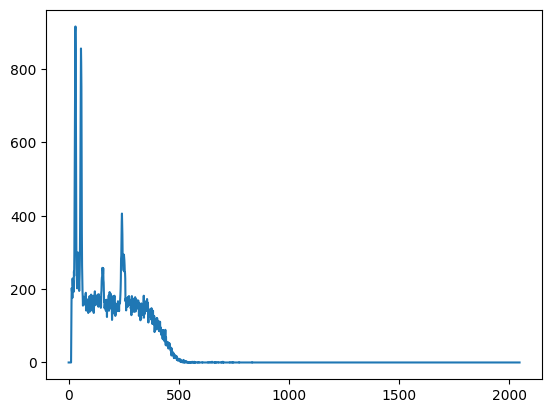

In [8]:
from EDS_simulator import EDS_Manager
import matplotlib.pyplot as plt
EDS = EDS_Manager((256, 256))

spectrum = np.load(r"C:\Users\labuser\Downloads\PyPhenom (2.1)\PyPhenom\Jacques_Argonne_Internship\Phenom Repositories\SLADS-Net_V3\SLADS-Net\Jacques Random\Spectra\Spectrum_run_2025-08-22_10-47-36.npy")
plt.plot(spectrum)
idx = np.array([0, 1])
classification = EDS.update(idx, spectrum)
print(classification)

## Do a sampling round where I acquire some EDS Spectra and classify them using EDS Manager

['C:\\Users\\labuser\\AppData\\Local\\Programs\\Python\\Python311\\python311.zip', 'C:\\Users\\labuser\\AppData\\Local\\Programs\\Python\\Python311\\DLLs', 'C:\\Users\\labuser\\AppData\\Local\\Programs\\Python\\Python311\\Lib', 'C:\\Users\\labuser\\AppData\\Local\\Programs\\Python\\Python311', 'c:\\Users\\labuser\\Downloads\\PyPhenom (2.1)\\PyPhenom\\Jacques_Argonne_Internship\\Phenom Repositories\\SLADS-Net_V3', '', 'c:\\Users\\labuser\\Downloads\\PyPhenom (2.1)\\PyPhenom\\Jacques_Argonne_Internship\\Phenom Repositories\\SLADS-Net_V3\\Lib\\site-packages', 'c:\\Users\\labuser\\Downloads\\PyPhenom (2.1)\\PyPhenom\\Jacques_Argonne_Internship\\Phenom Repositories\\SLADS-Net_V3\\Lib\\site-packages\\win32', 'c:\\Users\\labuser\\Downloads\\PyPhenom (2.1)\\PyPhenom\\Jacques_Argonne_Internship\\Phenom Repositories\\SLADS-Net_V3\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\labuser\\Downloads\\PyPhenom (2.1)\\PyPhenom\\Jacques_Argonne_Internship\\Phenom Repositories\\SLADS-Net_V3\\Lib\\site-pac

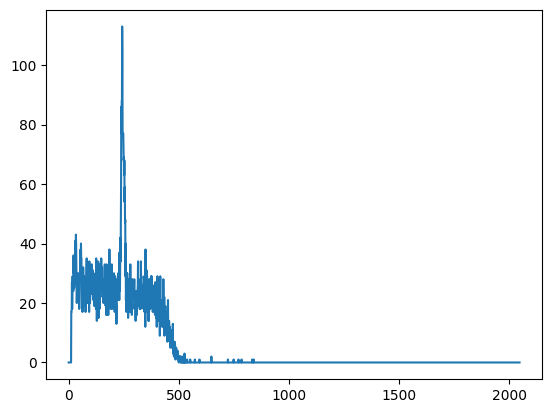

In [9]:
from perform_EDS_measurements import perform_single_EDS_measurement # Jacques updated EDS measurement code
import os
import sys
print(sys.path)
sys.path.append(r"C:\Users\labuser\Downloads\PyPhenom (2.1)\PyPhenom\Jacques_Argonne_Internship\Phenom Repositories\SLADS-Net_V3\SLADS-Net\measurement")
import numpy as np
from EDS_simulator import EDS_Manager
import matplotlib.pyplot as plt
EDS = EDS_Manager((256, 256))

# Acquire spectrum
idx = np.array([128, 128])
spectrum = np.array(perform_single_EDS_measurement(idx))
print(f'The twenty second element of the spectrum is {spectrum[22]}')
# Save numpy array for investigation
os.chdir(r"C:\Users\labuser\Downloads\PyPhenom (2.1)\PyPhenom\Jacques_Argonne_Internship\Phenom Repositories\SLADS-Net_V3\SLADS-Net\Jacques Random\WrongClassifications")
np.save("Tin Spectra", spectrum)

# Classify lead spectrum
classification = EDS.update(idx, spectrum)
plt.plot(spectrum)
print(f'Lead classification is {classification}')

# Acquire tin spectrum

# lead_idx = np.array([0, 0])
# lead_spectrum = np.array(perform_single_EDS_measurement(lead_idx))

# # Classify tin spectrum
# classification_lead = EDS.update(idx, spectrum)
# print(f'Lead classification is {classification_lead}')
